# Identifying cars on the street
In this notebook, we will identify cars on the street and calculate the area of the street that is covered by cars. We use a deterministic approach rather than an AI-Based approach. The idea is to label each car with a unique label and then calculate the area of the street that is covered by cars. We will start with the predicted mask, select the pixels which belong to the label, apply the connected components algorithm to label each car with a unique label, and then calculate the area of the street that is covered by cars. Also we calculate the centroid of each car and calculate the distance between each car and its neighbors. 

In [1]:
%pip install opencv-python

import cv2


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
# load the image and convert it to np array
def load_image(imagePath):
    if imagePath.endswith(".npy"):
        image = np.load(imagePath)
        # convert 1 to 255
        image[image == 1] = 255
    else:
        image = cv2.imread(imagePath)
    return image


def convert_image(image):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # make it to 0 and 255
    gray_image[gray_image == 38] = 255
    print(np.unique(gray_image))
    
    # Check if the image is already binary
    if not np.array_equal(np.unique(gray_image), [0, 38]):
        print("not binary")
        # Apply a threshold to convert it to binary
        _, binary_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)
    else:
        binary_image = gray_image
    return binary_image


In [12]:
import numpy as np

def dfs(image, labels, x, y, current_label):
    # if is out of bounds
    if x < 0 or y < 0 or x >= image.shape[1] or y >= image.shape[0]:
        return
    # if it is not a car or is already labeled, return 
    if labels[y, x] != 0 or image[y, x] != 255:
        return
    # else, label it that this pixel is part of the current label
    labels[y, x] = current_label 

    # 4-connectivity: left, right, up, down
    dfs(image, labels, x-1, y, current_label)
    dfs(image, labels, x+1, y, current_label)
    dfs(image, labels, x, y-1, current_label)
    dfs(image, labels, x, y+1, current_label)

In [13]:

def connected_components(image):
    labels = np.zeros_like(image)
    label = 1

    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            # if it is a car and is not labeled yet, search for adjacent pixels 
            if image[y, x] == 255 and labels[y, x] == 0:
                dfs(image, labels, x, y, label)
                label += 1

    return label - 1, labels

# Your binary image here (0 and 255)
# Make sure the image is binary (0 and 255)

In [15]:
# Count the components
num_cars, labeled_image = connected_components(load_image("images/label.npy"))
# num_cars, labeled_image = connected_components(convert_image(load_image("images/label.png"))
print(f"Number of cars: {num_cars}")

Number of cars: 7


In [16]:
import numpy as np
def generate_colors_for_cars(n):
    return [tuple(np.random.choice(range(1,256), size=3)) for _ in range(n)]

unique_values = np.unique(labeled_image)
unique_values_without_black = unique_values[unique_values != 0]
print(unique_values)
colors = generate_colors_for_cars(len(unique_values_without_black))
colors = [(0, 0, 0)] + colors
color_map = {value: color for value, color in zip(unique_values, colors)}
print(color_map)
# Create an RGB image
rgb_image = np.zeros((labeled_image.shape[0], labeled_image.shape[1], 3), dtype=np.uint8)
for value, color in color_map.items():
    rgb_image[labeled_image == value] = color

[0 1 2 3 4 5 6 7]
{0: (0, 0, 0), 1: (148, 35, 138), 2: (63, 127, 89), 3: (8, 52, 22), 4: (27, 19, 148), 5: (1, 215, 6), 6: (176, 199, 73), 7: (69, 97, 148)}


In [17]:
cv2.imwrite('output_image.png', rgb_image)

True

In [18]:
np.unique(labeled_image)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint8)

In [19]:
import numpy as np

# Assuming 'labeled_image' is your labeled image and 'num_labels' is the number of cars

centroids = []

for label in range(1, num_cars + 1):  # Starting from 1 as 0 is usually the background
    # Find the coordinates of pixels that belong to the current label
    y, x = np.where(labeled_image == label)

    # Calculate the centroid
    centroid_x = np.mean(x)
    centroid_y = np.mean(y)

    centroids.append((centroid_x, centroid_y))

# 'centroids' now contains the centroid coordinates for each car
centroids

[(839.3181818181819, 380.9227272727273),
 (433.8880079286422, 473.788899900892),
 (568.5394112060778, 496.8746438746439),
 (636.9884792626729, 513.7776497695853),
 (660.9502314814815, 639.9386574074074),
 (683.1051912568306, 647.139344262295),
 (783.7213483146068, 786.2202247191011)]

In [20]:
distances = {}

# Calculate pairwise distances
for i in range(len(centroids)):
    for j in range(i+1, len(centroids)):
        # Coordinates of the two centroids
        x1, y1 = centroids[i]
        x2, y2 = centroids[j]

        # Euclidean distance calculation
        distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

        # Store the distance
        distances[(i, j)] = distance
distances

{(0, 1): 415.92998439485757,
 (0, 2): 294.5606721506798,
 (0, 3): 242.0490424848793,
 (0, 4): 314.49066404402066,
 (0, 5): 308.6645194729887,
 (0, 6): 409.0929837236489,
 (1, 2): 136.6160751134515,
 (1, 3): 206.99976225147296,
 (1, 4): 281.35919264213396,
 (1, 5): 303.5779653175305,
 (1, 6): 469.0380568496158,
 (2, 3): 70.50522339586482,
 (2, 4): 170.31462553778434,
 (2, 5): 188.95713307845256,
 (2, 6): 360.5885899636804,
 (3, 4): 128.41637519252046,
 (3, 5): 141.11021466612166,
 (3, 6): 309.4438422482091,
 (4, 5): 23.29575355788019,
 (4, 6): 190.97393556089915,
 (5, 6): 171.65984495424507}

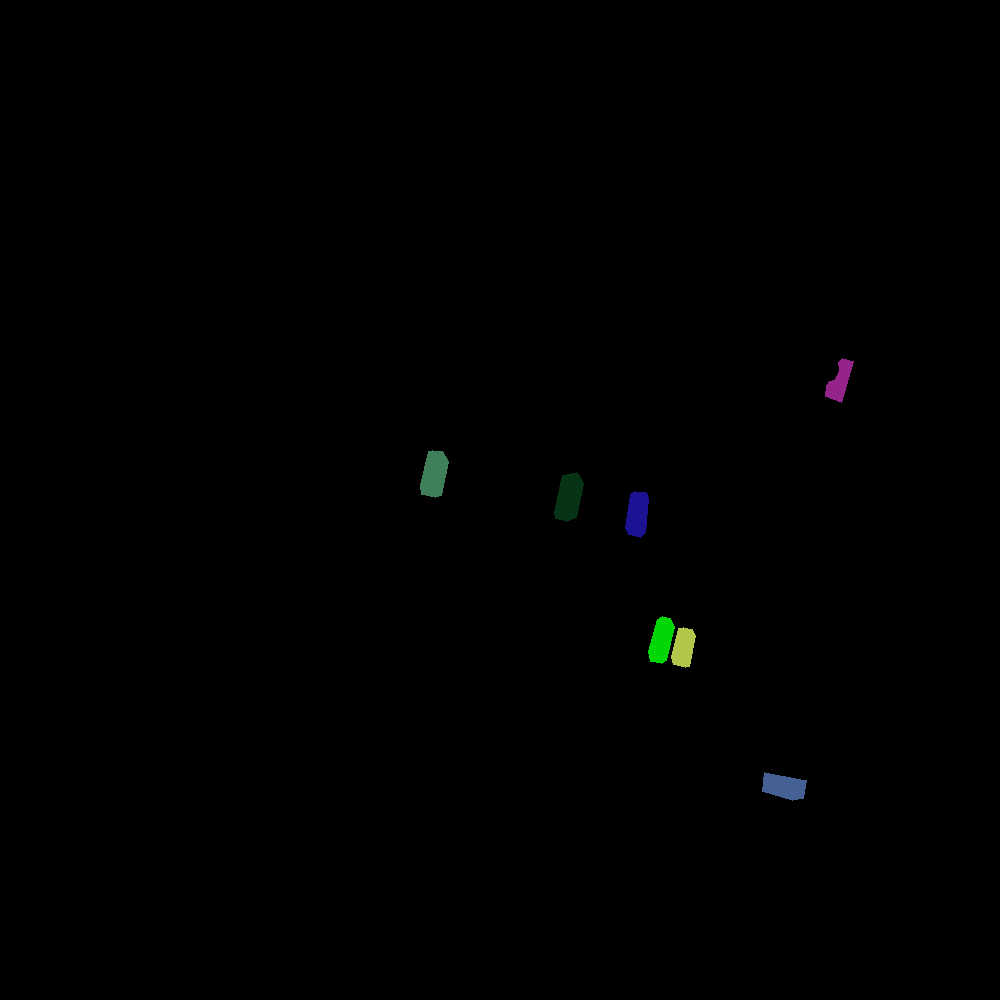

In [150]:
from PIL import Image

# Assuming 'labeled_image' is your labeled image where each car has a unique label
# 'original_image' should be your original RGB image
colored_image_for_plotly = Image.fromarray(rgb_image)
colored_image_for_plotly

In [155]:
import plotly.graph_objects as go

fig = go.Figure()
img_width = 1000
img_height = 1000
scale_factor = 1
adjusted_centroids = [(x, img_height - y) for x, y in centroids]

for i, (x, y) in enumerate(adjusted_centroids):
    hovertext = f"Car {i}<br>" + "<br>".join(
        [f"Distance to Car {j}: {dist:.2f}" for (k, j), dist in distances.items() if k == i] +
        [f"Distance to Car {k}: {dist:.2f}" for (k, j), dist in distances.items() if j == i]
    )
    color = colored_image_for_plotly.getpixel((int(x), -int(y-1000)))
    color_rgba = f'rgba({color[0]}, {color[1]}, {color[2]}, 1)'

    print(x)
    print(y)
    print(color)
    fig.add_trace(go.Scatter(x=[x], y=[y],marker=dict(color=color_rgba),mode='markers', hoverinfo='text', hovertext=hovertext))



fig.update_xaxes(showgrid=False, visible=False, range=[0, colored_image_for_plotly.size[0]])
fig.update_yaxes(showgrid=False, visible=False, range=[0, colored_image_for_plotly.size[1]])
fig.add_layout_image(
    dict(
        source=colored_image_for_plotly,
            xref="x",
            yref="y",
        x=0,
        sizex=img_width * scale_factor,
        y=img_height * scale_factor,
        sizey=img_height * scale_factor,
            sizing="stretch",
            opacity=1,
            layer="below")
)
# Add scatter trace for centroids

# Update layout
fig.update_layout(
    template="plotly_white",
    showlegend=True,
    width=colored_image_for_plotly.size[0],
    height=colored_image_for_plotly.size[1]
)

fig.show()

839.3181818181819
619.0772727272727
(148, 35, 138)
433.8880079286422
526.2111000991081
(63, 127, 89)
568.5394112060778
503.1253561253561
(8, 52, 22)
636.9884792626729
486.2223502304147
(27, 19, 148)
660.9502314814815
360.0613425925926
(1, 215, 6)
683.1051912568306
352.860655737705
(176, 199, 73)
783.7213483146068
213.7797752808989
(69, 97, 148)


 ## Calculate street area

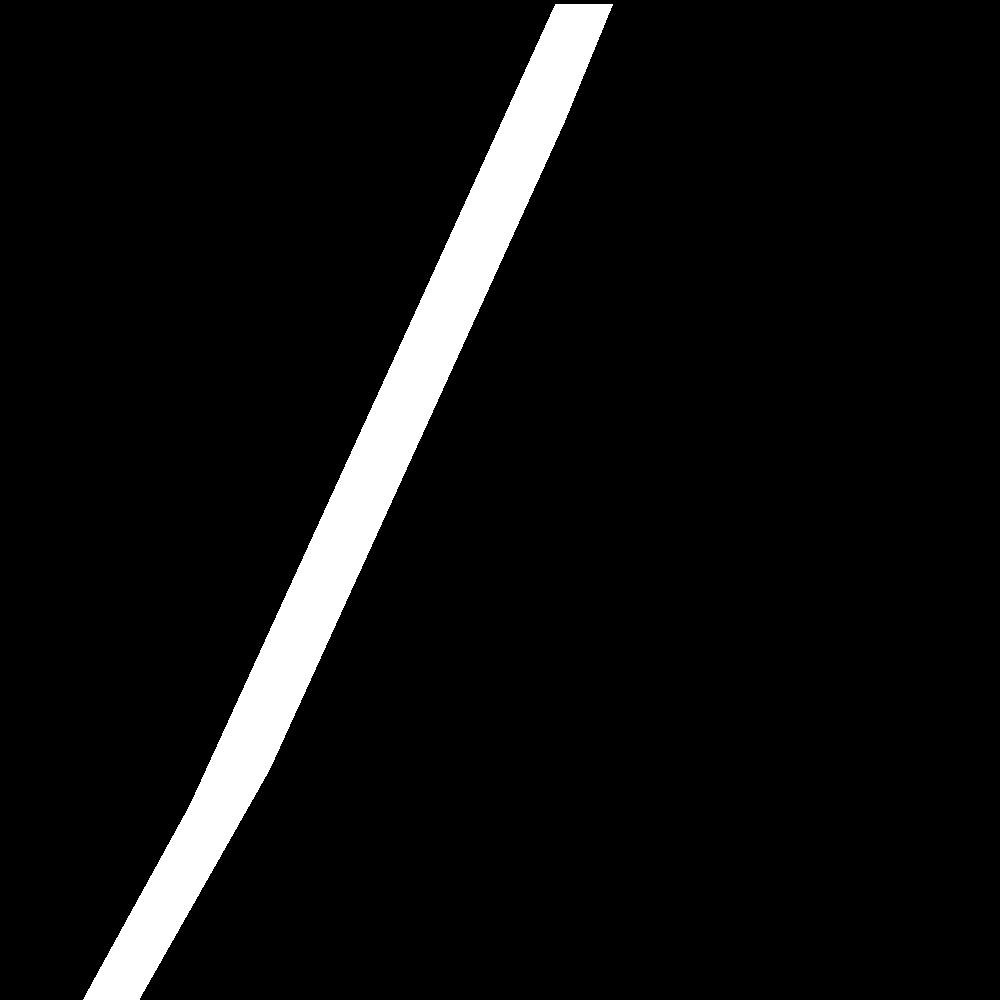

In [156]:
# load the image as np array
image_street = load_image("images/label_street_mask.npy")
image_vis = Image.fromarray(image_street)
image_vis

In [161]:
# calculate the number of pixels that are street
num_street_pixels = np.sum(image_street == 255)
num_street_pixels

61781

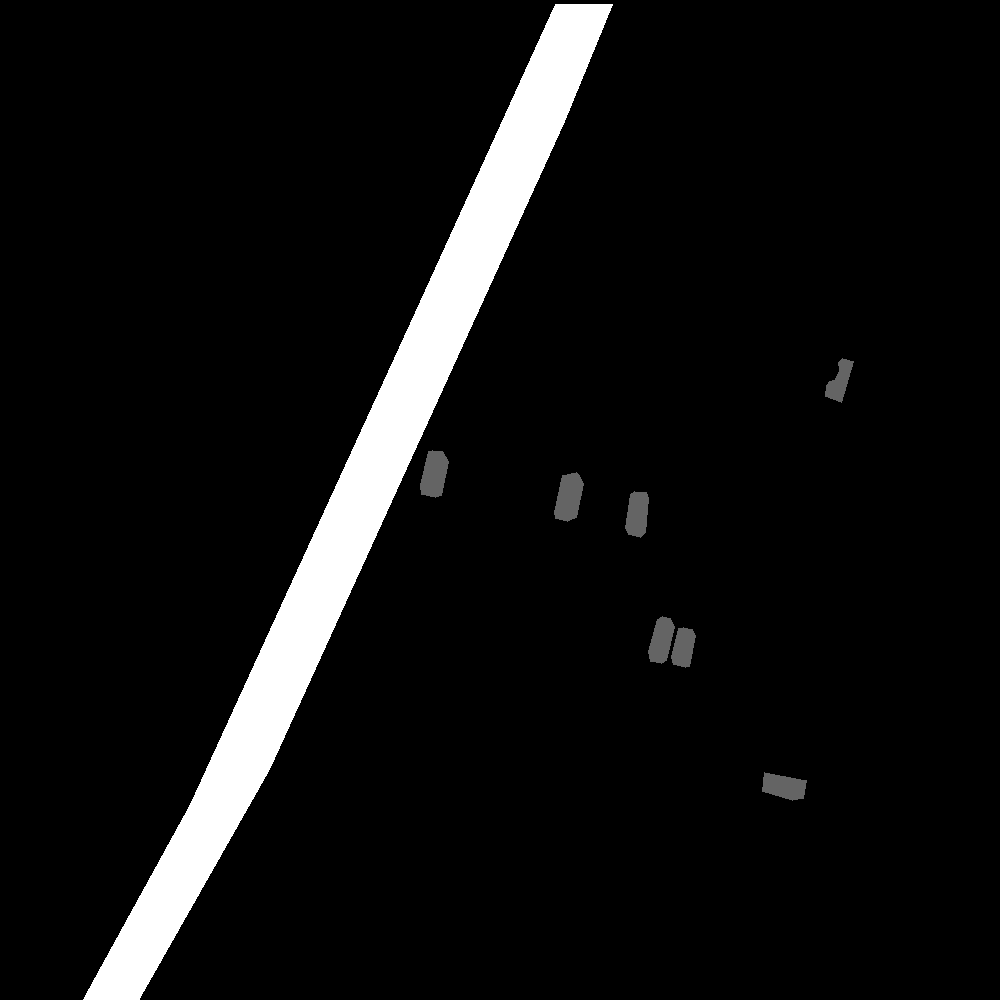

In [166]:
# put cars on the street
image_street_with_cars = image_street.copy()
image_street_with_cars[labeled_image != 0] = 100
# put the cars on the street

# paint the cars in red
image_vis = Image.fromarray(image_street_with_cars)
image_vis   


In [167]:
# calculate the cars on the street
num_cars_on_street = np.sum(image_street_with_cars == 100)

In [168]:
num_cars_on_street

6076